# Explore nationalities in relation to evolution over time

In [123]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

### Create a Pandas dataframe from a SQL query

In [3]:
### Define the path to the file (a string in a variable 'db_file')
# if the data directory label is at the same level as the notebook,
# then the path is 'data/astronomers_import.db'
db_file_address = '../../data/astronomers_import.db'

In [235]:
### Create a connection to the SQLite database of your repository
# Beware : if the database does not exist at the specified address (db_file_address)
# it will be created and will be empty. Therefore, carefully check the database address
try:
    cn = sql.connect(db_file_address)    
except Exception as e:
    # if the connection does not work
    # an error message is raised
    print(e)    


In [236]:
### This ist the query that produces the data to be analysed.
# It has to be adapted to each use case
q1 = """
WITH tw1 AS (
SELECT natio_code, SUM(eff) as effectif_tot
from code_nationality_country
GROUP BY natio_code ),
--count each person just once
tw2 AS (
SELECT subject_uri, COUNT(*) eff, min(natio_country) natio_country, max(birthyear) birthyear
FROM dbp_person_countries dpc 
group by subject_uri)
SELECT tw2.birthyear, tw1.natio_code, tw1.effectif_tot
FROM tw2
   JOIN code_nationality_country cnc ON cnc.natio_country = tw2.natio_country 
   JOIN tw1 ON tw1.natio_code = cnc.natio_code 
WHERE LENGTH(cnc.natio_code) > 0
ORDER BY birthyear ;     
"""

In [237]:
### This instruction executes the query 
# then closes the connection to the database 
c_df= pd.read_sql_query(q1, cn)
cn.close()
# Inspect the first lines
print(c_df.head())

   birthyear natio_code  effectif_tot
0       1380   Austrian            72
1       1404    Italian           219
2       1423    Italian           219
3       1423   Austrian            72
4       1436     German           369


In [238]:
### Inspect maximum and minimum birth dates
print(c_df.birthyear.min(), c_df.birthyear.max())

1380 1993


In [239]:
### Exclude rows with 10 or less persons
c_df = c_df[c_df.effectif_tot > 10].sort_values(by=['natio_code','birthyear'])
print(c_df.tail())

      birthyear natio_code  effectif_tot
2027       1953      Swiss            56
2138       1961      Swiss            56
2162       1963      Swiss            56
2189       1966      Swiss            56
2195       1966      Swiss            56


In [240]:
### Count how many persons you have per country (natio_code): distribution
dc_df = c_df[['natio_code','effectif_tot']].groupby('natio_code').max()
dc_df

,effectif_tot
natio_code,
American,664
Argentinian,18
Austrian,72
British,300
Dutch,94
French,329
German,369
Indian,112
Italian,219


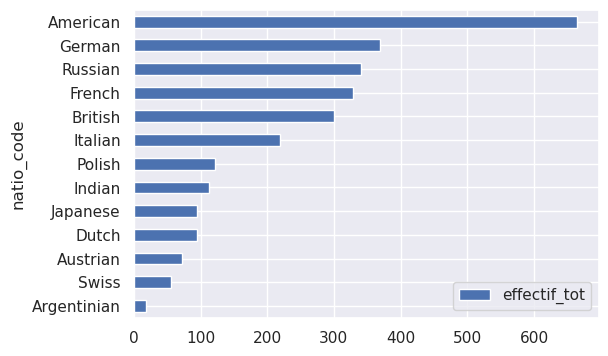

In [241]:
### Plot the distribution
dc_df.sort_values(by='effectif_tot').plot(kind='barh', figsize=(6,4))
plt.show()

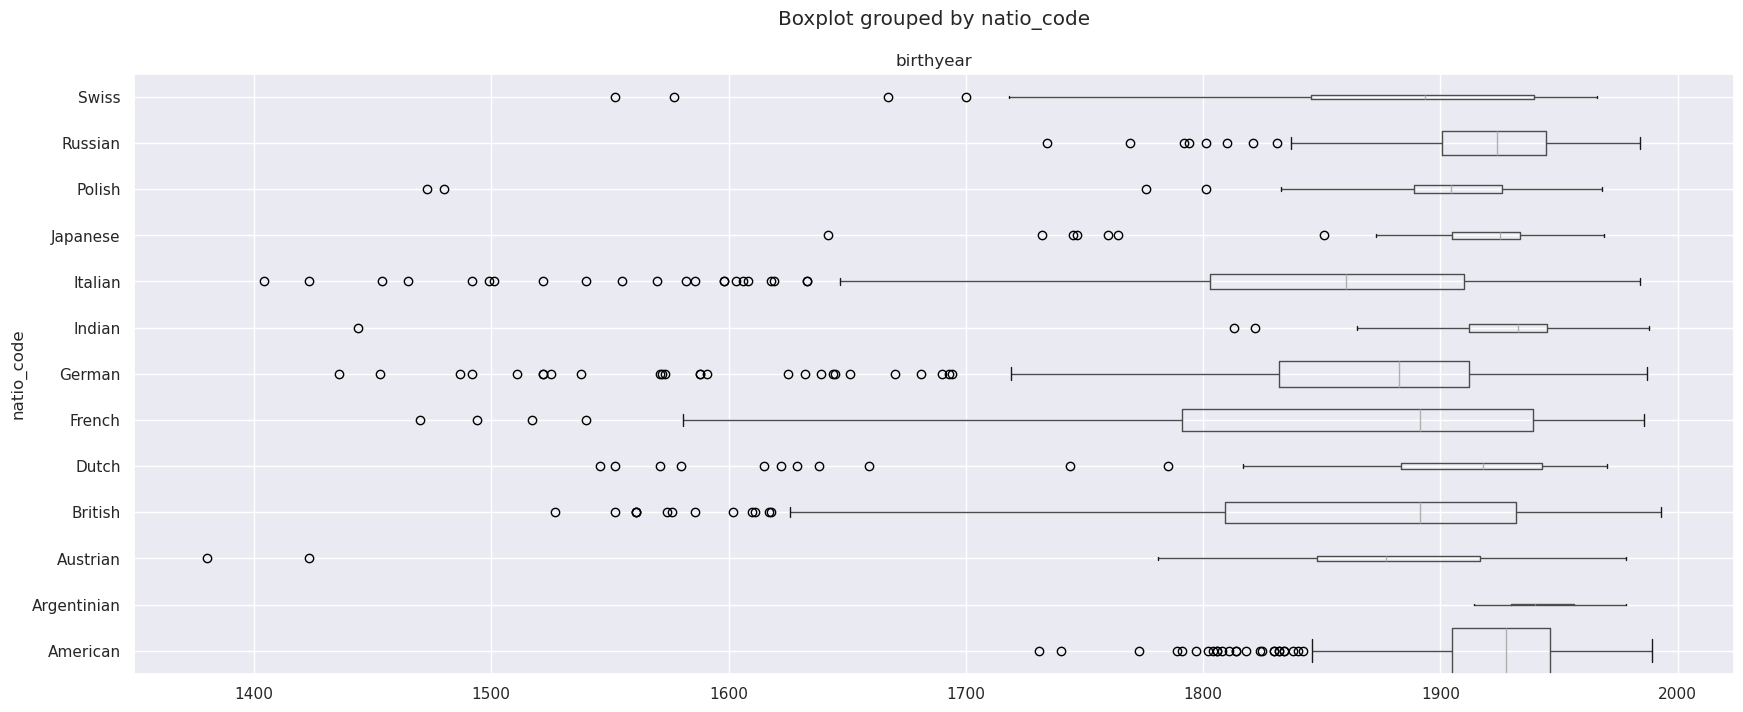

In [242]:
total = float(sum(counts))
widths = [c/max(counts) for c in counts] 
c_df.sort_values(by='natio_code', ascending=True).boxplot(column='birthyear', by='natio_code',  
          vert=False, widths=widths, figsize=(20,8))
plt.show()

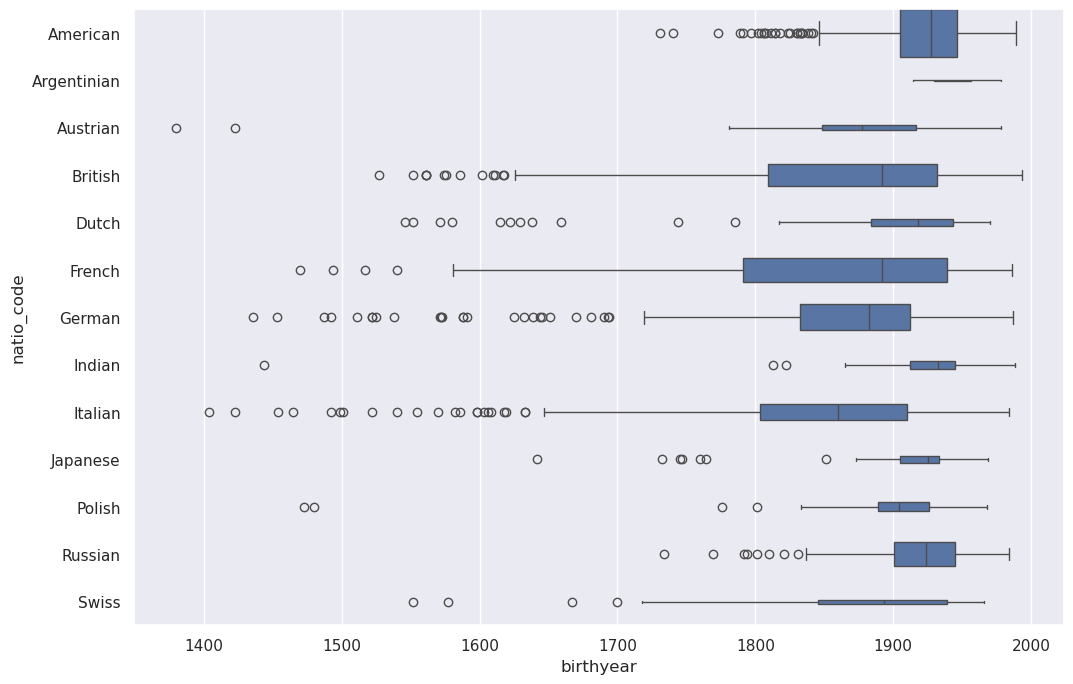

In [283]:
sns.set_theme(rc={'figure.figsize':(12,8)})

counts= dc_df.effectif_tot
total = float(sum(counts))
widths = [c/max(counts) for c in counts] 
sns.boxplot(y=c_df["natio_code"], x=c_df.birthyear, width=widths)

plt.savefig('pictures/natio_code_birth_boxplot_20241216.png')
plt.show()

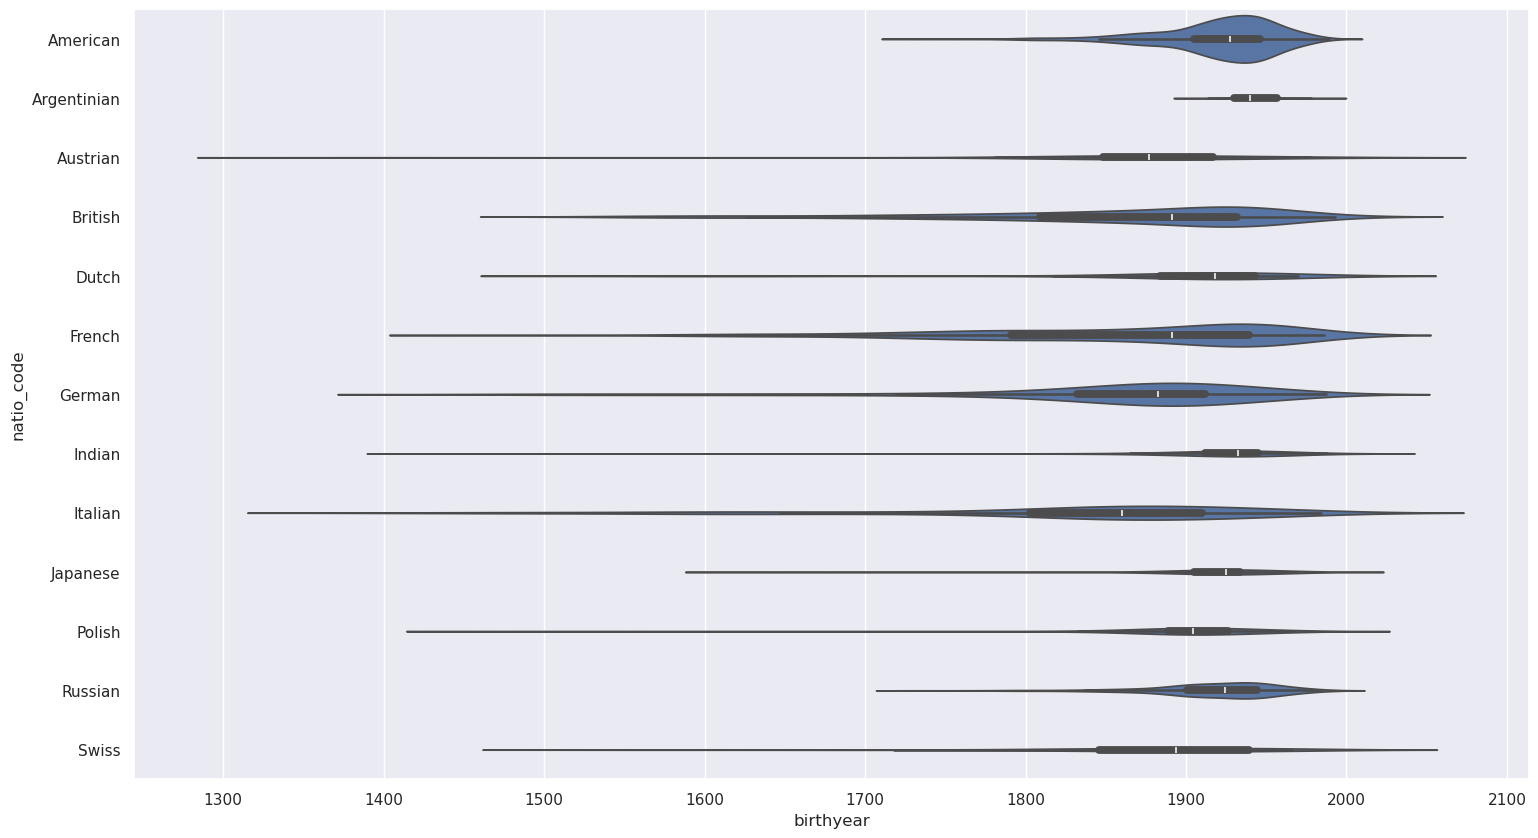

In [278]:
### Allows to inspect identity zones but not the proportion to global number
sns.set_theme(rc={'figure.figsize':(18,10)})

## noter que "density_norm" remplace "scale='count'"
sns.violinplot(y='natio_code', x='birthyear', data=c_df, 
               density_norm='count')
plt.show()

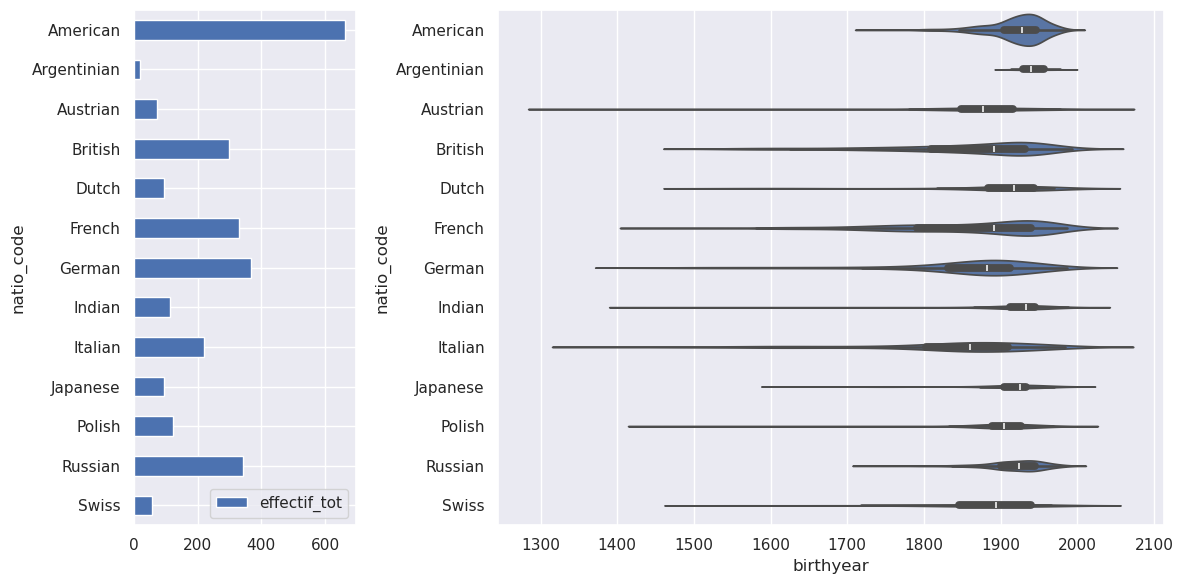

In [245]:
fig, (ax1, ax2) = plt.subplots(ncols=2, width_ratios=[1, 3])

gd_df = c_df[['natio_code','effectif_tot']].groupby(by=['natio_code']).max()\
      .sort_index(ascending=False).plot(kind='barh', figsize=(12,6), ax=ax1)

ax2 = sns.violinplot(y='natio_code', x='birthyear', data=c_df, density_norm='count')

# évite les superpositions
fig.tight_layout()

plt.savefig('pictures/natio_code_birth_year_20241209.png')
plt.show()

## Bivariate analysis of qualitative variables: time and country

In [66]:
print(min(c_df.birthyear), max(c_df.birthyear))

1380 1993


In [249]:
### Créer une liste d'années pour séparer en périodes de 25 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_20 = list(range(1841, 2002, 20))
print(l_20)

[1841, 1861, 1881, 1901, 1921, 1941, 1961, 1981, 2001]


In [254]:
## Adapt values in relation to the time
l_years = [1351, 1551, 1651, 1751, 1776, 1801, 1826, 1841, 1861, 1881, 1901, 1921, 1941, 1961, 1981, 2001]

In [255]:
### fonction pd.cut
# This separation of periods isn't finegraded enough to make phenomena visible

c_df['Périodes'] = pd.cut(c_df.birthyear, l_years, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
c_df['Périodes'] = c_df['Périodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
c_df.head(3)

,birthyear,natio_code,effectif_tot,Périodes
150,1731,American,664,1651-1750
168,1740,American,664,1651-1750
215,1773,American,664,1751-1775


In [256]:
### fonction pd.qcut
# cuts the timeline in 10 periods with similar frequency of births, making them comparable

## test with 15 or 20 periods to see the difference

#c_df['Périodes'] = pd.qcut(c_df.birthyear, q=15)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
#c_df['Périodes'] = c_df['Périodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
c_df.head(3)

,birthyear,natio_code,effectif_tot,Périodes
150,1731,American,664,1651-1750
168,1740,American,664,1651-1750
215,1773,American,664,1751-1775


In [257]:
### group and count births
cdfp = c_df[['Périodes']].groupby(by='Périodes', observed=False).size()
cdfp.head()

Périodes
1351-1550    29
1551-1650    63
1651-1750    91
1751-1775    39
1776-1800    63
dtype: int64

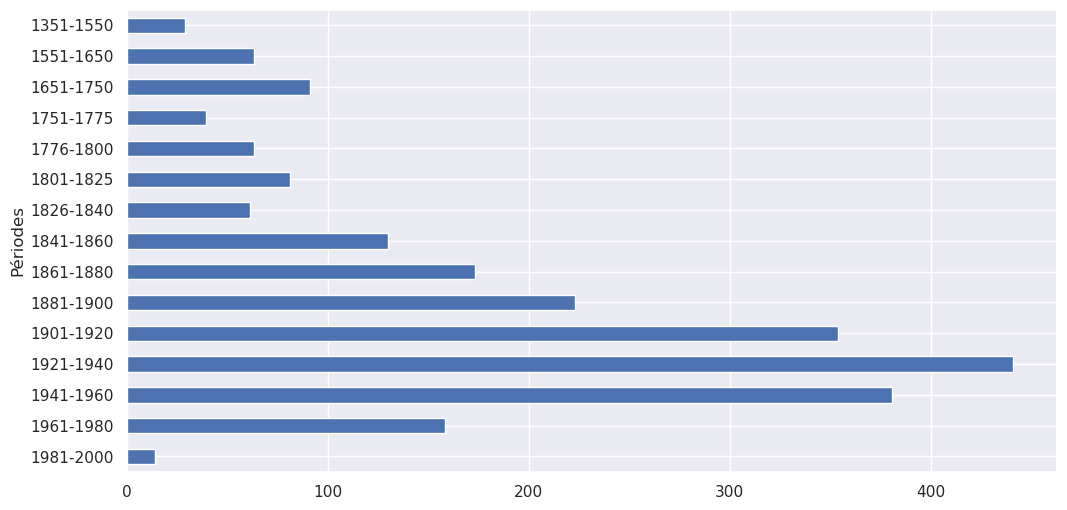

In [258]:
### group and count births
f = cdfp.sort_index(ascending=False).plot(kind='barh', figsize=(12,6))


In [259]:
## Calculate the pivot table 

X = 'Périodes'
Y = 'natio_code'

ddf = c_df[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf

natio_code,American,Argentinian,Austrian,British,Dutch,French,German,Indian,Italian,Japanese,Polish,Russian,Swiss,Total
Périodes,,,,,,,,,,,,,,
1351-1550,0,0,2,1,1,4,9,1,9,0,2,0,0,29
1551-1650,0,0,0,16,7,11,11,0,15,1,0,0,2,63
1651-1750,2,0,0,23,2,32,14,0,11,3,0,1,3,91
1751-1775,1,0,0,9,0,15,6,0,5,2,0,1,0,39
1776-1800,3,0,3,12,1,22,14,0,5,0,1,2,0,63
1801-1825,11,0,3,13,1,15,13,2,15,0,1,3,4,81
1826-1840,8,0,1,11,0,3,18,0,11,0,3,4,2,61
1841-1860,21,0,10,17,3,21,23,0,21,1,1,6,6,130
1861-1880,45,0,8,17,5,17,36,5,19,2,5,11,3,173


In [260]:
## Total number
n = ddf.iloc[-1,-1]
print(n)

2301


In [261]:
## Pivot table without borders
D = ddf.iloc[:-1,:-1].copy(deep=True)
# D

In [262]:
### Valeurs produites par une fonction
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic, ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),1)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)

Chi2 : 734.1629142939987 , dof : 168
p-value : 9.302598833119551e-72
phi2 = inertie (variance totale) : 0.31906254423902597
Cramer:  0.16305994404896673


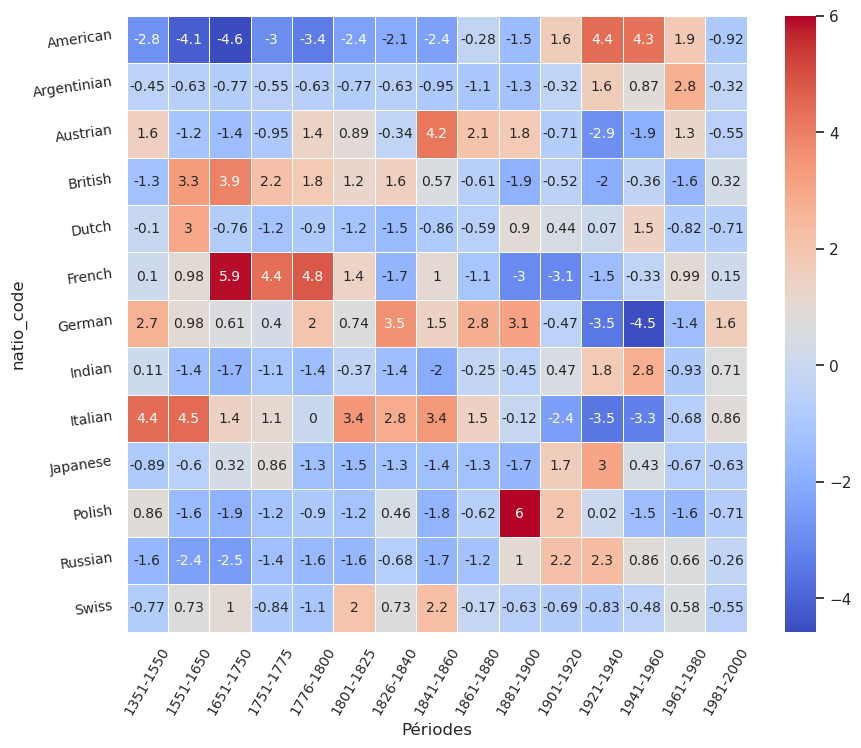

In [271]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D.values-dfe)/np.sqrt(dfe),2))
residus_ponderes.columns= D.columns
residus_ponderes.index=D.index

residus_ponderes_T = residus_ponderes.transpose()

fig, ax = plt.subplots(figsize=(10,8))
# Sample figsize in inches
g = sns.heatmap(residus_ponderes_T, annot=residus_ponderes_T, 
                cmap="coolwarm", linewidths=.5, ax=ax,
                annot_kws={"fontsize":10})
labels = residus_ponderes_T.index
cols = residus_ponderes_T.columns
c = g.set_xticklabels(cols, rotation=60, size=10)
p = g.set_yticklabels(labels, rotation=8, size=10)

plt.savefig('pictures/natio_code_birth_period_20241216.png')

plt.show()


## Factor correpondence analysis : time and country

In [263]:
from fanalysis.ca import CA

# Calculate the factors of Factor correpondence analysis (FCA)
afc = CA(row_labels=D.index,col_labels=D.columns)
afc.fit(D.values)

In [266]:
#nombre de modalités ligne
K = D.shape[0]

#nombre de modalités colonnes
L = D.shape[1]

# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 15 , 13 ), effectif: 2301 , nombre max. facteurs: 12


In [267]:
#affichage des valeurs propres
print(afc.eig_)

[[1.81707125e-01 6.97506298e-02 2.33687060e-02 1.84535222e-02
  7.67545365e-03 6.47298513e-03 5.02854969e-03 3.02014879e-03
  2.77064794e-03 4.77637665e-04 3.04727006e-04 3.24113192e-05]
 [5.69503153e+01 2.18611150e+01 7.32417716e+00 5.78366924e+00
  2.40562667e+00 2.02875118e+00 1.57603886e+00 9.46569518e-01
  8.68371419e-01 1.49700325e-01 9.55069819e-02 1.01582965e-02]
 [5.69503153e+01 7.88114303e+01 8.61356075e+01 9.19192768e+01
  9.43249034e+01 9.63536546e+01 9.79296935e+01 9.88762630e+01
  9.97446344e+01 9.98943347e+01 9.99898417e+01 1.00000000e+02]]


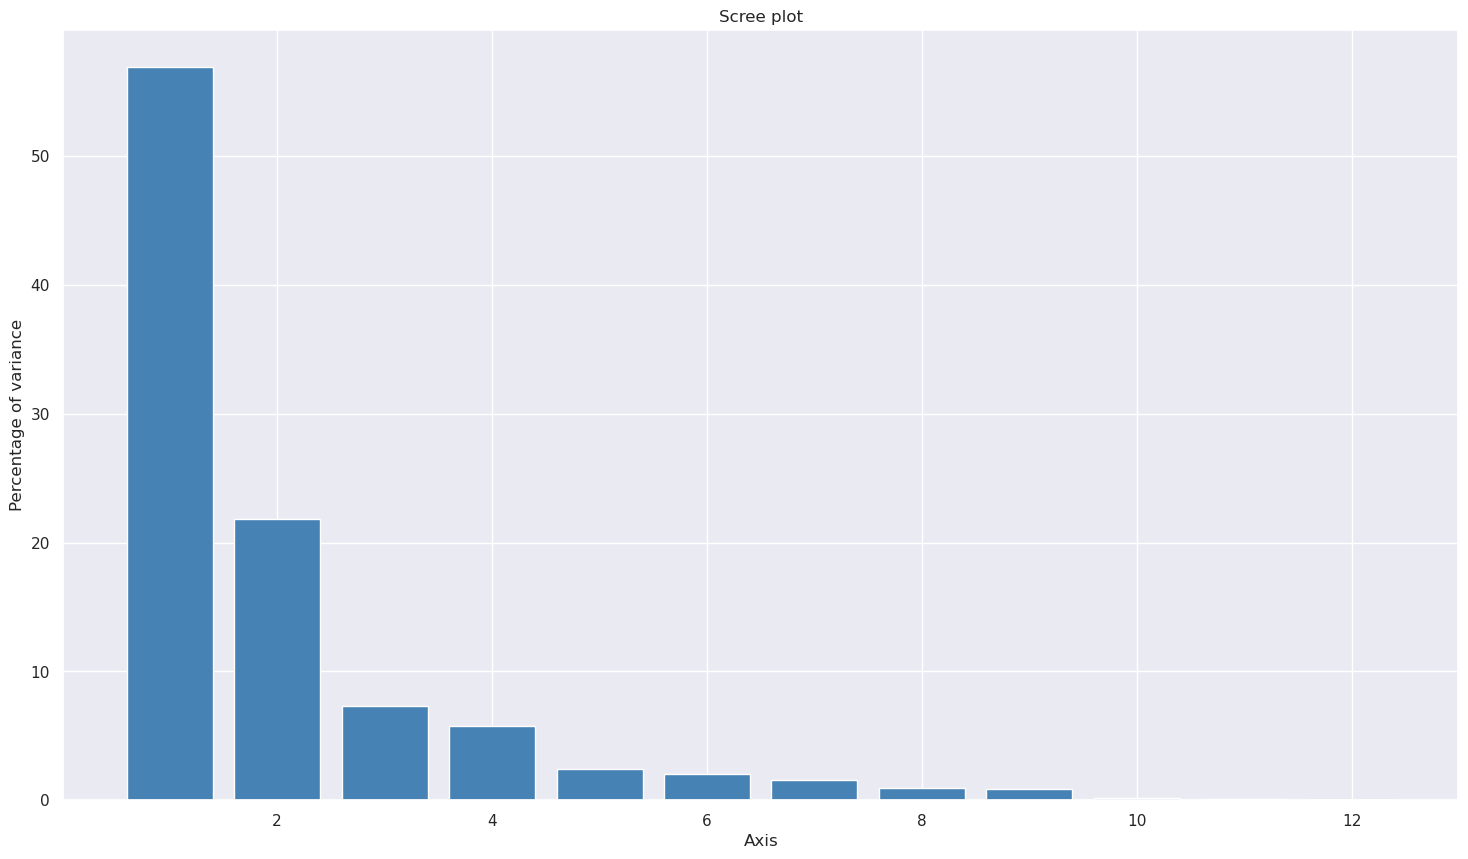

In [268]:
ax = afc.plot_eigenvalues('percentage')

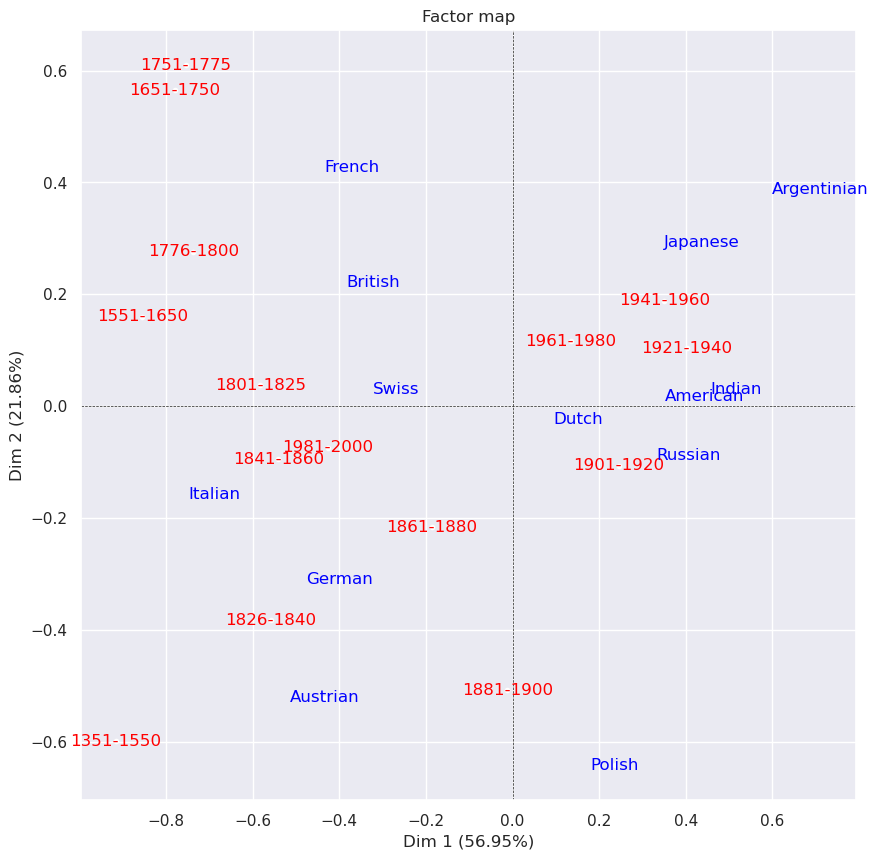

In [269]:
# First two factors
afc.mapping(num_x_axis=1,num_y_axis=2,figsize=(10,10))

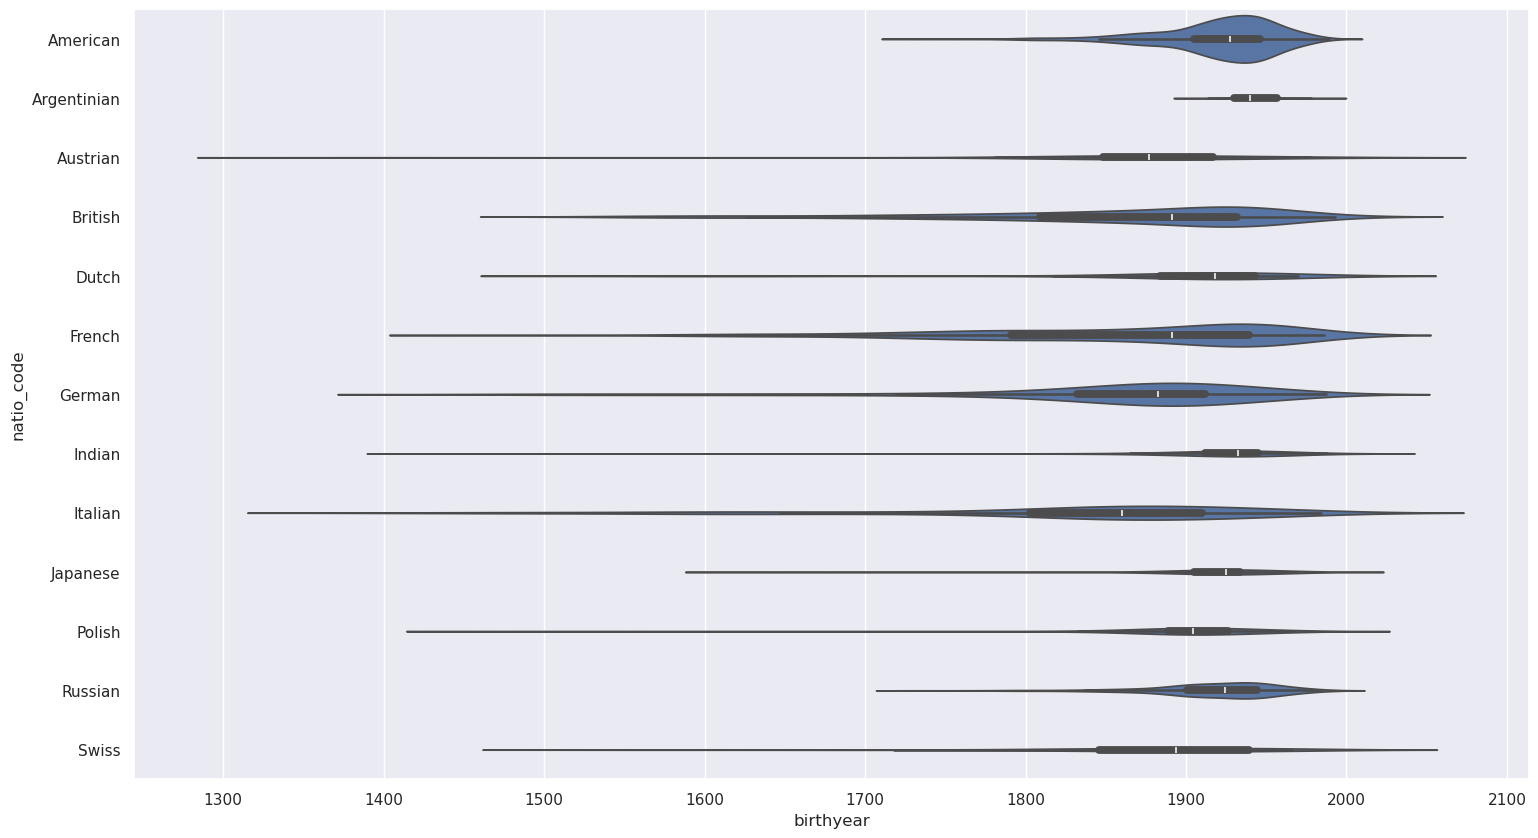

In [270]:
### Allows to inspect density zones and the proportion to global number
sns.set_theme(rc={'figure.figsize':(18,10)})

## noter que "density_norm" remplace "scale='count'"
sns.violinplot(y='natio_code', x='birthyear', data=c_df, density_norm='count')
plt.show()